### Imports and pre-processing

In [89]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Defining colors for each day of the week
colors = ['darkorange', 'lightsalmon', 'coral', 'red', 'wheat', 'seagreen', 'mediumaquamarine']


In [34]:
MunichData2023 = "./Munich_h_2023.csv"
MunichData2020 = "./Munich_h_2020.csv"
MunichData2019 = "./Munich_h_2019.csv"

df_2023 = pd.read_csv(MunichData2023)
df_2020 = pd.read_csv(MunichData2020)
df_2019 = pd.read_csv(MunichData2019)

/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_36729/3289889142.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2019 = pd.read_csv(MunichData2019)


In [58]:
# Filter rows which have "Erherdt" in the column "zaehlstelle" for 2023
df_2023_Erhardt = df_2023[df_2023['zaehlstelle'].str.contains("Erhardt")].copy()
# Transform the column "gesamt" from float to int
df_2023_Erhardt['gesamt'] = df_2023_Erhardt['gesamt'].astype(int)

# Filter rows which have "Erherdt" in the column "zaehlstelle" for 2020
df_2020_Erhardt = df_2020[df_2020['zaehlstelle'].str.contains("Erhardt")]


# Filter rows which have "Erherdt" in the column "zaehlstelle" for 2019
df_2019_Erhardt = df_2019[df_2019['zaehlstelle'].str.contains("Erhardt")].copy()
# Transform the column "gesamt" from float to int
df_2019_Erhardt['gesamt'] = df_2019_Erhardt['gesamt'].astype(int)

In [83]:
# Concatenate the dataframes for 2019, 2020 and 2023 into one dataframe for Erhardt street in Munich 
df_Erhardt = pd.concat([df_2019_Erhardt, df_2020_Erhardt, df_2023_Erhardt]).reset_index()

print(df_Erhardt.head())

# Drop columns which are not needed for the analysis
df_Erhardt.drop(columns=['zaehlstelle', 'kommentar', 'richtung_1', 'richtung_2', 'uhrzeit_ende'], inplace=True)
# Rename the columns for better understanding
df_Erhardt=df_Erhardt.rename(columns={
    'datum':'Date', 
    'uhrzeit_start': 'TimeStampStart',
    "gesamt": "Total"})

df_Erhardt.info()

# Make sure date is in datetime format
df_Erhardt['Date'] = pd.to_datetime(df_Erhardt['Date'])

# First, ensure any seconds in 'TimeStampStart' are removed or standardized to ':00' if they vary
df_Erhardt['TimeStampStart'] = df_Erhardt['TimeStampStart'].str.slice(start=0, stop=5)
# Then convert to datetime
df_Erhardt['TimeStampStart'] = pd.to_datetime(df_Erhardt['TimeStampStart'], format='%H:%M').dt.time

# Since the 'Date' column conversion is correct, we can move to creating the 'DateTime' column
from datetime import datetime
df_Erhardt['DateTime'] = df_Erhardt.apply(lambda row: datetime.combine(row['Date'], row['TimeStampStart']), axis=1)

# Drop the 'Date' and 'TimeStampStart' columns and the index column
df_Erhardt.drop(columns=['Date', 'TimeStampStart', 'index'], inplace=True)

# Reset the index
df_Erhardt.reset_index(drop=True, inplace=True)

# Reorder the columns
df_Erhardt = df_Erhardt[['DateTime', 'Total']]

# Set the 'DateTime' column as the index
df_Erhardt.set_index('DateTime', inplace=True)

# Resample and aggregate to hourly totals
hourly_data = df_Erhardt['Total'].resample('H').sum()

# Reset the index
hourly_data=hourly_data.reset_index()

hourly_data.head()


   index       datum uhrzeit_start uhrzeit_ende zaehlstelle  richtung_1  \
0  14880  2019-01-01      00:00:00     00:15:00     Erhardt         0.0   
1  14881  2019-01-01      00:15:00     00:30:00     Erhardt         0.0   
2  14882  2019-01-01      00:30:00     00:45:00     Erhardt         0.0   
3  14883  2019-01-01      00:45:00     01:00:00     Erhardt         0.0   
4  14884  2019-01-01      01:00:00     01:15:00     Erhardt         2.0   

   richtung_2  gesamt kommentar  
0         0.0       0       NaN  
1         2.0       2       NaN  
2         1.0       1       NaN  
3         2.0       2       NaN  
4         1.0       3       NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105216 entries, 0 to 105215
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           105216 non-null  int64 
 1   Date            105216 non-null  object
 2   TimeStampStart  105216 non-null  object
 3   Total

/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_36729/887287077.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = df_Erhardt['Total'].resample('H').sum()


,DateTime,Total
0,2019-01-01 00:00:00,5
1,2019-01-01 01:00:00,24
2,2019-01-01 02:00:00,22
3,2019-01-01 03:00:00,20
4,2019-01-01 04:00:00,11


In [94]:
# First we want to extract the hour from the 'DateTime' column and add it as a new column called 'Hour'
hourly_data['Hour'] = hourly_data['DateTime'].dt.hour

# Extract the day of the week from the 'DateTime' column and add it as a new column called 'DayOfWeek'
hourly_data['DayOfWeek'] = hourly_data['DateTime'].dt.dayofweek + 1

# Extract the month from the 'DateTime' column and add it as a new column called 'Month'
hourly_data['Month'] = hourly_data['DateTime'].dt.month

# Extract the year from the 'DateTime' column and add it as a new column called 'Year'
hourly_data['Year'] = hourly_data['DateTime'].dt.year

# Group so that we can calculte the average number of cyclists per hour for each day of the week depending on the month
grouped = hourly_data.groupby(['Year', 'Month', 'DayOfWeek', 'Hour'])['Total'].mean()

# Display the first few rows of the grouped dataframe
print(grouped)


Year  Month  DayOfWeek  Hour
2019  1      1          0        3.50
                        1        1.50
                        2        1.00
                        3        0.25
                        4        1.75
                                ...  
2023  12     7          19      36.60
                        20      23.40
                        21      24.40
                        22      18.80
                        23      11.20
Name: Total, Length: 10080, dtype: float64


### Plots

In [99]:
# # Plot the average number of cyclists per hour for each day of the week depending on the month in 12 subplots with different colors for each day of the week
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

# # Adjust the loop to iterate over months only, given your subplot configuration
# for month, data in grouped.groupby(level=0):
#     ax = axes[(month-1) // 3, (month-1) % 3]  # Calculate subplot position
#     month_data = data.unstack(level=1)  # Unstack to get day of week on one level
#     month_data.plot(ax=ax, title=f'Month {month}, 2019', color=colors)
#     ax.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
    
# plt.tight_layout()
# plt.show()

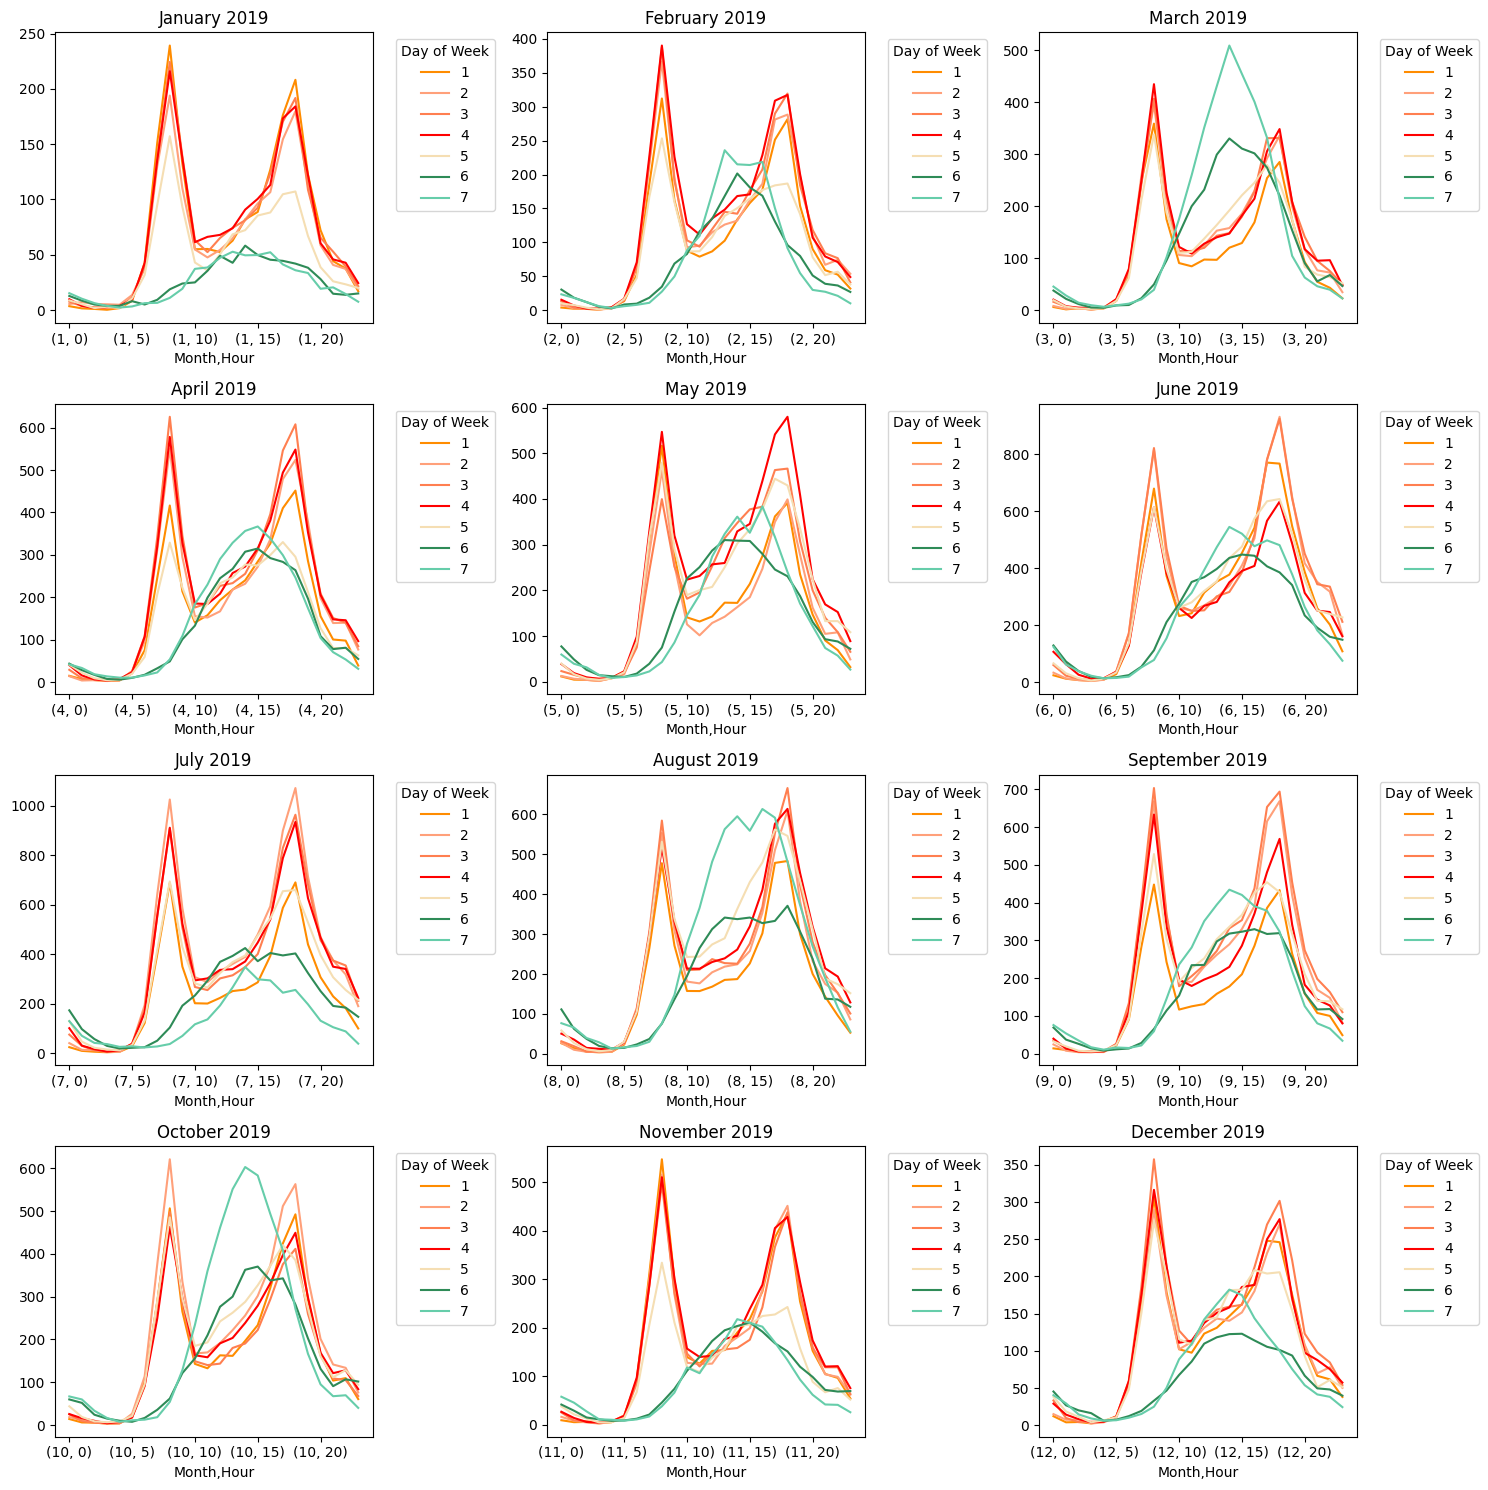

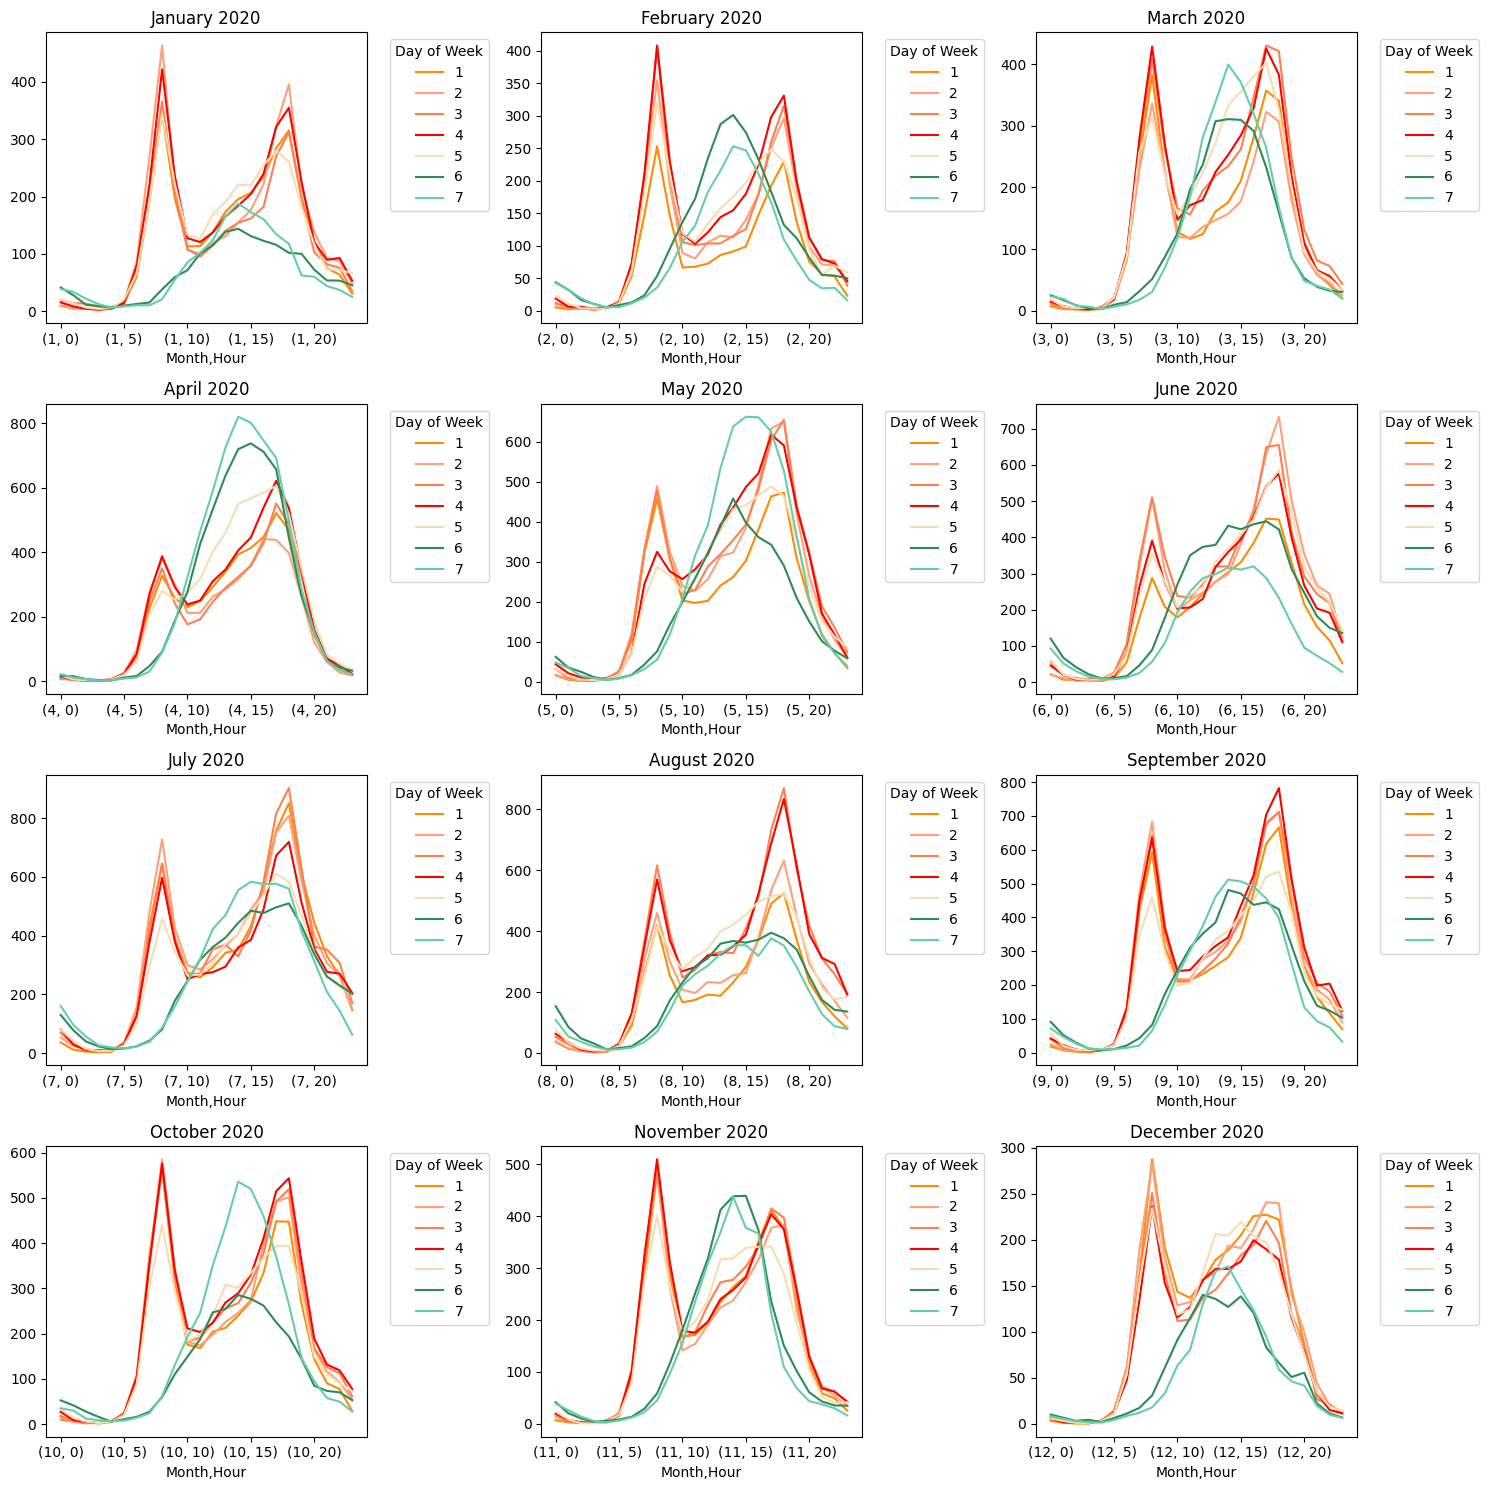

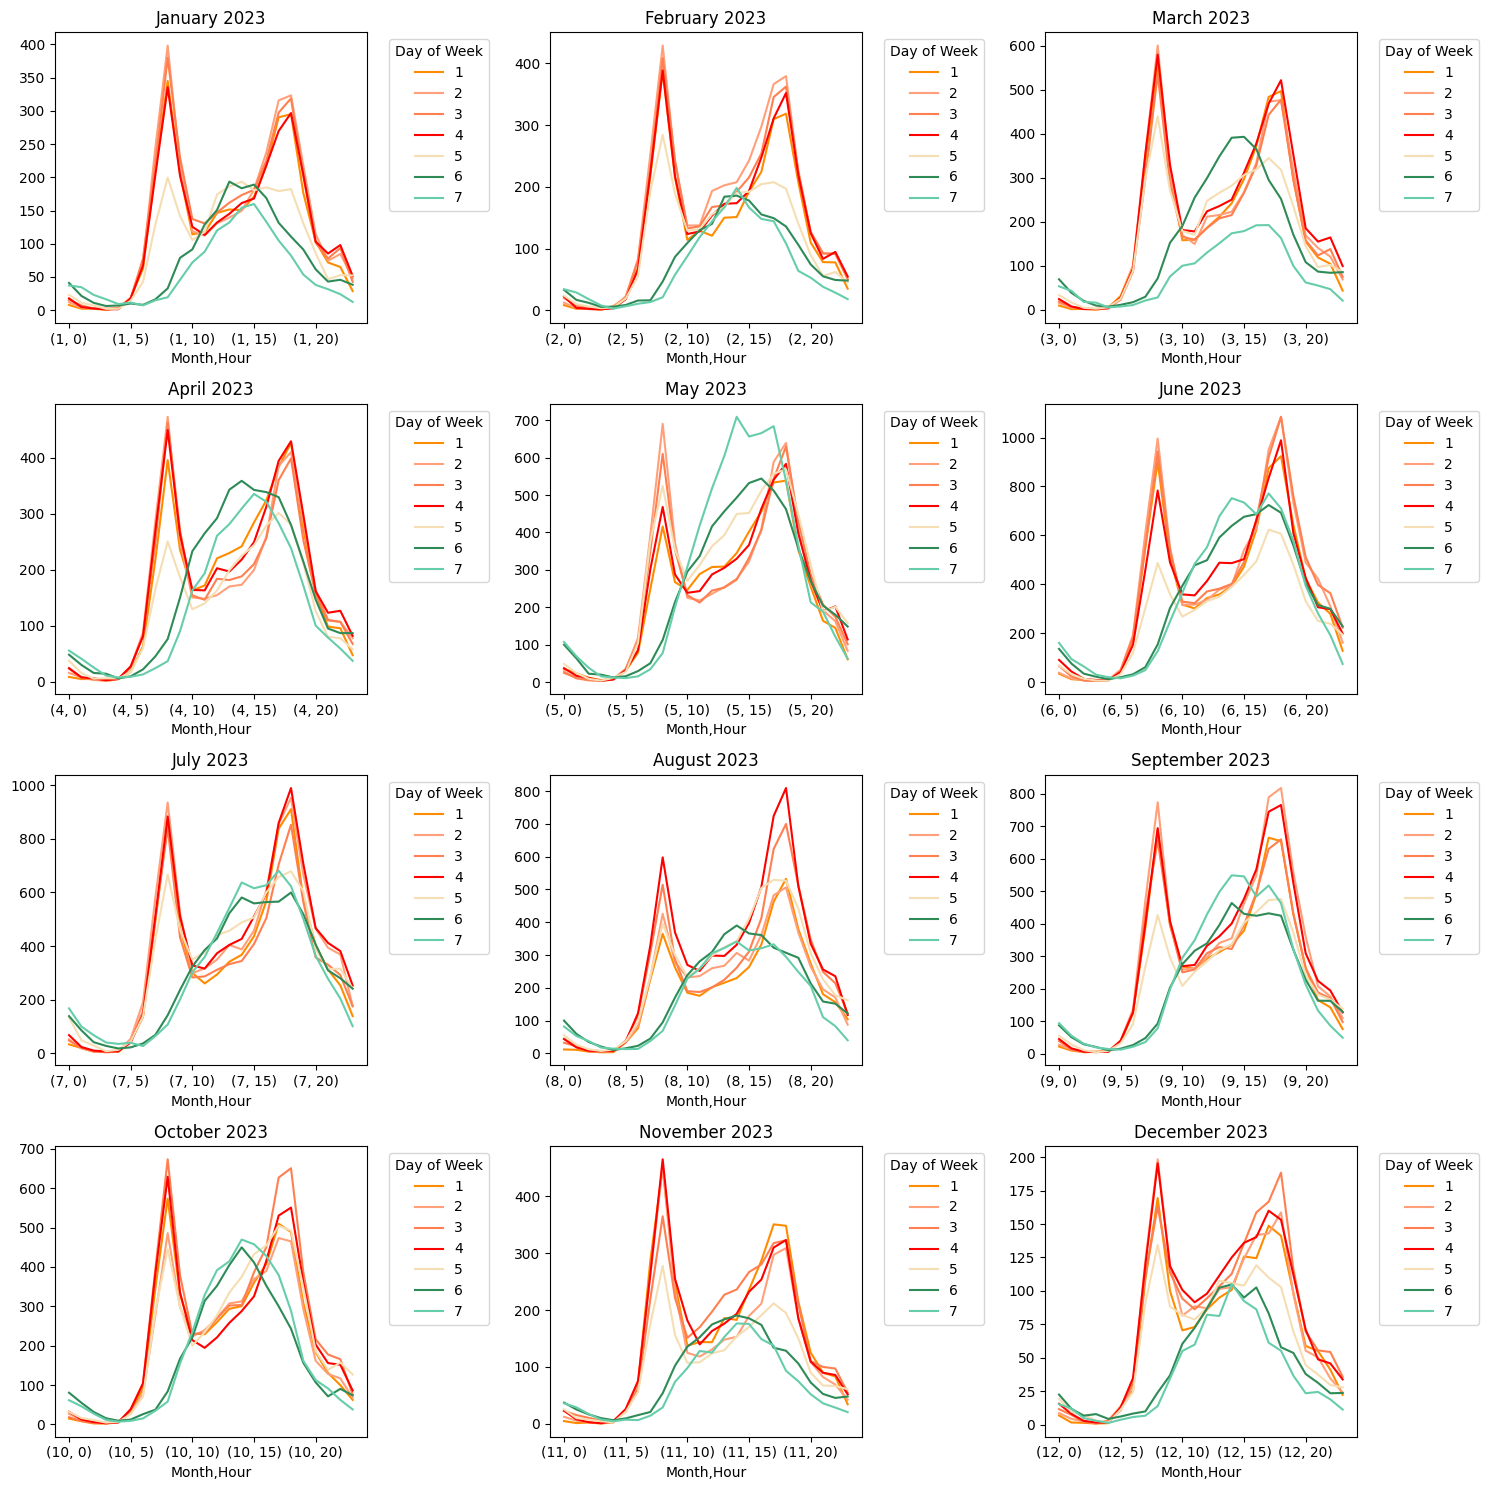

In [98]:
# Create an array of months names to use in the plots below
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot for each year the average number of cyclists per hour for each day of the week depending on the month
for year in [2019, 2020, 2023]:
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
    for month, data in grouped.xs(year).groupby(level=0):
        ax = axes[(month-1) // 3, (month-1) % 3]  # Calculate subplot position
        month_data = data.unstack(level=1)  # Unstack to get day of week on one level
        month_data.plot(ax=ax, title=f'{months[month-1]} {year}', color=colors)
        ax.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()